In [1]:
## !git clone https://github.com/dustineby/neutron_reflect2

In [2]:
## cd neutron_reflect/

In [3]:
## Import Python related required packages
import io
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sea

from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
import random

## Import torch related packages
import torch
import torchvision
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

## Import packages from the github clone
import dataprep as dpre
import autoencoderv2 as ae
import mlp as mlp

In [4]:
colors = sea.color_palette('tab10',10)
sea.set_theme(context='paper', style='whitegrid', palette='tab10')

In [5]:
## Set random seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [6]:
## Load data into numpy arrays
data_path = './data/'
expt_arr = np.load(os.path.join(data_path,'mod_expt.npy'))
sld_arr = np.load(os.path.join(data_path,'mod_sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'mod_params_fp49.npy'))

In [7]:
## Set parameters

## Dimension of the latent space 
latent_dim = 2
dim_list = [('l' + str(i + 1)) for i in range(latent_dim)]
## Parameter size
num_params = params_arr.shape[1]
## Dimension of the input curves
in_d1 = 2
in_d2 = 72
## Number of epochs
ae_epochs = 200
mlp_epochs = 200
## Batch size
batch_size = 16

In [8]:
## Find and remove flat data from dataset
flat_data = []
for i in range(sld_arr.shape[0]):
  y_start = sld_arr[i,1,0]
  if (sld_arr[i,1,1] == y_start and sld_arr[i,1,2] == y_start):
    flat_data.append(i)

sld_arr_clean = np.delete(sld_arr, flat_data, 0)
params_arr_clean = np.delete(params_arr, flat_data, 0)

sld_arr_clean.shape, params_arr_clean.shape

((5902, 2, 72), (5902, 3))

In [9]:
## Remove non-impact chi1 data points
## How much of the

bad_chi1 = []
for i in range(sld_arr_clean.shape[0]):
  if (params_arr_clean[i,0] <= 0.07 or params_arr_clean[i,0] >= 0.12):
    bad_chi1.append(i)

sld_arr_cut = np.delete(sld_arr_clean, bad_chi1, 0)
params_arr_cut = np.delete(params_arr_clean, bad_chi1, 0)

sld_arr_cut.shape, params_arr_cut.shape

((1931, 2, 72), (1931, 3))

In [10]:
## Find ranges of paramters for nomalization

chi1_vals = params_arr_cut[:,0]
chi1_min, chi1_max  = chi1_vals.min(), chi1_vals.max()
print('chi1-range= ', chi1_min, ' to ', chi1_max)

chi2_vals = params_arr_cut[:,1]
chi2_min, chi2_max  = chi2_vals.min(), chi2_vals.max()
print('chi2-range= ', chi2_min, ' to ', chi2_max)

chi3_vals = params_arr_cut[:,2]
chi3_min, chi3_max  = chi3_vals.min(), chi3_vals.max()
print('chi3-range= ', chi3_min, ' to ', chi3_max)

## Norm data [-1,1]

params_arr_cut[:,0] = ((params_arr_cut[:,0] - chi1_min) * 2/(chi1_max - chi1_min)) - 1
params_arr_cut[:,1] = ((params_arr_cut[:,1] - chi2_min) * 2/(chi2_max - chi2_min)) - 1
params_arr_cut[:,2] = ((params_arr_cut[:,2] - chi3_min) * 2/(chi3_max - chi3_min)) - 1

chi1-range=  0.0701  to  0.119
chi2-range=  -0.6  to  0.6
chi3-range=  -0.59951  to  0.59976


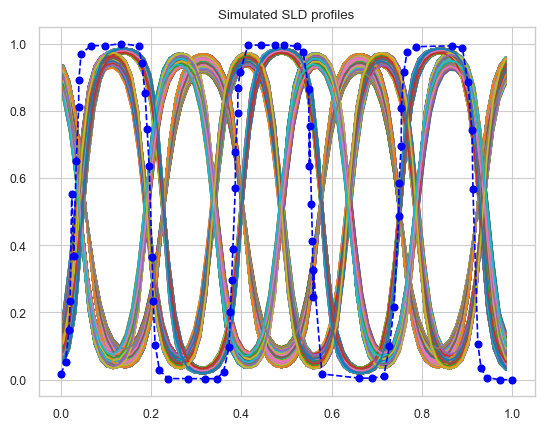

In [11]:
## Show simulated curves vs experiment

for i in range(sld_arr_cut.shape[0]):
  plt.plot(sld_arr_cut[i][0],sld_arr_cut[i][1])
plt.title('Simulated SLD profiles')
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [12]:
## Split data files
list_arrays = dpre.split_arrays(sld_arr_cut, params_arr_cut, size_split = 0.7)

## Convert to tensors
tensor_arrays = [torch.from_numpy(array).float() for array in list_arrays]

## Create dataloaders from tensors
tr_data, val_data, tst_data, tr_load, val_load, tst_load = dpre.get_dataloaders(*tensor_arrays, batch_size)

In [13]:
## Set loss function, establish processor type
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [14]:
## Initialize autoencoder, train it, save loss numbers
autoencoder = ae.Autoencoder(144, latent_dim)

ae_train_loss, ae_val_loss = ae.train(autoencoder, tr_load, val_load, ae_epochs, loss_fn)

Epoch: 1, train loss: 0.07882297407178318, valid loss: 0.0648396591606893
Epoch: 2, train loss: 0.057608341075041716, valid loss: 0.03415770671869579
Epoch: 3, train loss: 0.024648744437624426, valid loss: 0.01686184059240316
Epoch: 4, train loss: 0.008050933133755975, valid loss: 0.0018239201316119808
Epoch: 5, train loss: 0.0010787812493029325, valid loss: 0.0008326768170503017
Epoch: 6, train loss: 0.0007809331811800161, valid loss: 0.0007372219942657179
Epoch: 7, train loss: 0.0006921736591988626, valid loss: 0.0006283827701975641
Epoch: 8, train loss: 0.0006172270055257661, valid loss: 0.0005839648840360736
Epoch: 9, train loss: 0.0005899131133714143, valid loss: 0.0005573458405897805
Epoch: 10, train loss: 0.0005722181642126731, valid loss: 0.0005666694150453335
Epoch: 11, train loss: 0.0005707004645099753, valid loss: 0.0005328503964272769
Epoch: 12, train loss: 0.0005563482518910485, valid loss: 0.0005305355727231424
Epoch: 13, train loss: 0.0005420756553683211, valid loss: 0.0

Text(0.5, 1.0, 'Autoencoder Training')

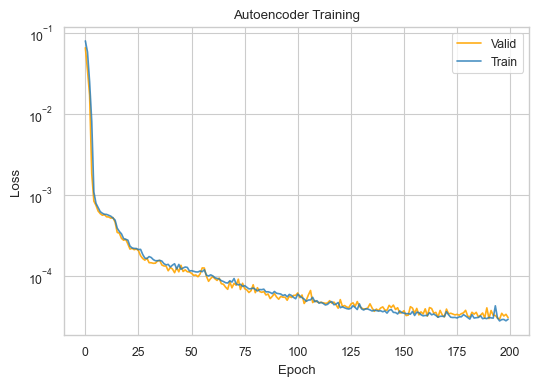

In [15]:
## Chart autoencoder training and validation loss per epoch
plt.figure(figsize=(6,4))
plt.semilogy(ae_val_loss, label='Valid', color = 'orange', alpha=.9)
plt.semilogy(ae_train_loss, label='Train', alpha=0.8)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training')

## Log y-axis range, if we want to chart other loss curves on the same scale
#bottom,top = plt.ylim()

In [16]:
## Run our training set through the final model, gather latent vectors, and store in a pandas dataframe
encoded_samples = []
for sample in tr_data:
    curve = sample[0].view(sample[0].size(0), -1).flatten().to(device)
    labels = sample[1]
    autoencoder.eval()
    with torch.no_grad():
      latent_vars = autoencoder.encoder(curve).numpy()
    latent_sample = {f"l{i+1}": var for i, var in enumerate(latent_vars)}
    for i in range(num_params):
      label_index = 'chi'+str(i+1)
      latent_sample[label_index] = labels[i].item()
    encoded_samples.append(latent_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)

Text(0, 0.5, '$\\ell_{2}$')

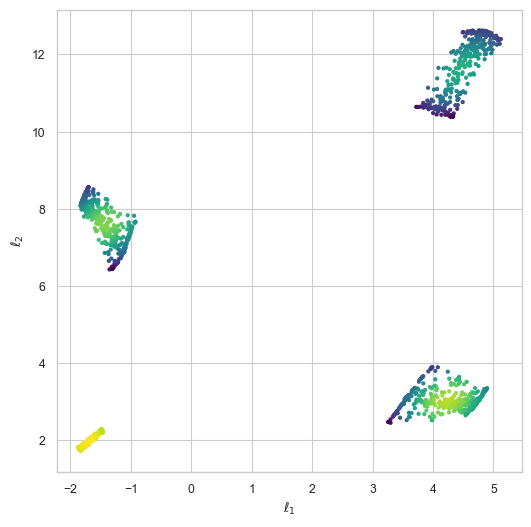

In [17]:
## Plotting the joint distributions for the latent variables for the simulated sld curves
## Only plots in 2 dimensions, so any latent space of dimension 3 or higher will need to be varied here
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
x = df_encoded_samples['l1']
y = df_encoded_samples['l2']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, cmap='viridis')
ax.set_xlabel('$\ell_{1}$')
ax.set_ylabel('$\ell_{2}$')

In [18]:
## Method to take a model and dataloader, and output 4 arrays as pytorch tensors:
## Input curves, output curves, latent space vectors, and chi parameters
def get_full_output(ae_model, dataloader):
    list_curves = []
    list_recon = []
    list_latent = []
    list_labels = []

    for curve, labels in dataloader:
        
        ae_model.eval()
        with torch.no_grad():
            latent_vars = ae_model.encoder(curve.view(curve.size(0), -1))
            recon_curve = ae_model.decoder(latent_vars)

        list_curves.append(curve)
        list_labels.append(labels)
        list_latent.append(latent_vars)
        list_recon.append(recon_curve)
    
    return [torch.cat(list_curves), torch.cat(list_recon), torch.cat(list_latent), torch.cat(list_labels)]

In [19]:
## Run above method for our training, validation, and testing datasets
full_data_train = get_full_output(autoencoder, tr_load)
full_data_valid = get_full_output(autoencoder, val_load)
full_data_test = get_full_output(autoencoder, tst_load)

mlp_input_data = [full_data_train[2], full_data_train[3], full_data_valid[2], full_data_valid[3], full_data_test[2], full_data_test[3]]

In [20]:
## Create MLP training sets, establish batch size for MLP model
mlp_tr_data, mlp_val_data, mlp_tst_data, mlp_tr_load, mlp_val_load, mlp_tst_load = dpre.get_dataloaders(*mlp_input_data, batch_size)

In [21]:
## Initialize MLP model, train it, store loss values
percep = mlp.deep_MLP(latent_dim, num_params)

train_loss, val_loss = mlp.train(percep, mlp_tr_load, mlp_val_load, mlp_epochs, loss_fn)

Epoch: 1, train loss: 0.22689818731125663, valid loss: 0.1932074686414317
Epoch: 2, train loss: 0.16715390366666458, valid loss: 0.1665009405267866
Epoch: 3, train loss: 0.15784942832063226, valid loss: 0.16186019346902245
Epoch: 4, train loss: 0.15106683610116733, valid loss: 0.1510197379087147
Epoch: 5, train loss: 0.13849715441465377, valid loss: 0.13806680393846413
Epoch: 6, train loss: 0.13035827840075773, valid loss: 0.13146142504717173
Epoch: 7, train loss: 0.12304417701328502, valid loss: 0.1269578494523701
Epoch: 8, train loss: 0.113698529057643, valid loss: 0.11286940386420802
Epoch: 9, train loss: 0.11215041621642954, valid loss: 0.11232637025808033
Epoch: 10, train loss: 0.10572553776642855, valid loss: 0.10234022062075765
Epoch: 11, train loss: 0.10348830586847137, valid loss: 0.10035061248038944
Epoch: 12, train loss: 0.09867069190915893, valid loss: 0.09305723384022713
Epoch: 13, train loss: 0.0917868777671281, valid loss: 0.08992033726290653
Epoch: 14, train loss: 0.089

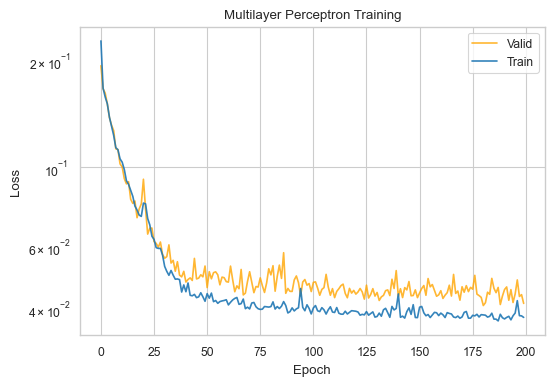

In [22]:
# Plot losses for MLP
plt.figure(figsize=(6,4))
plt.semilogy(val_loss, label='Valid', color = 'orange', alpha=0.8)
plt.semilogy(train_loss, label='Train', alpha=.9)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multilayer Perceptron Training')
plt.legend()



In [23]:
## Run our training data through our final MLP, store in pandas dataframe
train_samples = []
for sample in mlp_tr_data:
    img = sample[0]
    img = img.view(img.size(0), -1).flatten().to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    percep.eval()
    with torch.no_grad():
        out_label  = percep(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_chi{i+1}": enc for i, enc in enumerate(out_label)}
    for i in range(num_params):
      label_index = 'chi'+str(i+1)
      out_sample[label_index] = float(label_val[i])
    train_samples.append(out_sample)
df_train_samples = pd.DataFrame(train_samples)
df_train_samples

,pred_chi1,pred_chi2,pred_chi3,chi1,chi2,chi3
0,-0.752450,0.471221,0.553277,-0.918200,0.195000,0.656258
1,0.620590,0.352232,-0.430423,0.591002,0.576667,-0.506733
2,0.060226,0.522681,0.512088,0.018405,0.953333,0.537535
3,0.864057,0.483645,0.512378,1.000000,0.661667,0.827011
4,-0.780798,-0.330794,-0.855404,-0.844581,-0.465000,-0.976703
...,...,...,...,...,...,...
1346,-0.012119,0.519148,0.510484,-0.047035,0.466667,0.268272
1347,-0.735185,0.697096,-0.088380,-0.619632,0.835000,-0.164125
1348,0.852652,0.474561,0.517070,1.000000,0.052667,0.465992
1349,-0.694282,-0.907966,-0.285901,-0.750511,-0.995000,-0.223861


In [24]:
## Run our testing set through the MLP, store in a pandas dataframe
test_samples = []
for sample in mlp_tst_data:
    img = sample[0]
    img = img.view(img.size(0), -1).flatten().to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    percep.eval()
    with torch.no_grad():
        test_label  = percep(img)
    test_label = test_label.cpu().numpy()
    # print(enumerate(encoded_img))
    test_sample = {f"pred_chi{i+1}": enc for i, enc in enumerate(test_label)}
    for i in range(num_params):
      label_index = 'chi'+str(i + 1)
      test_sample[label_index] = float(label_val[i])
    test_samples.append(test_sample)
df_test_samples = pd.DataFrame(test_samples)
df_test_samples

,pred_chi1,pred_chi2,pred_chi3,chi1,chi2,chi3
0,-0.781367,-0.541791,0.531256,-0.959100,-0.590000,0.648986
1,-0.430683,0.507735,0.522433,-0.419223,0.488333,0.141611
2,-0.096746,0.523747,0.503167,-0.149284,0.830000,0.080007
3,0.250964,0.573406,-0.410394,0.263804,0.848333,-0.529447
4,-0.756326,0.395187,-0.531443,-0.631902,0.601667,-0.686609
...,...,...,...,...,...,...
285,0.678879,-0.441914,-0.437469,0.713701,-0.748333,-0.801396
286,-0.765553,0.250464,-0.541086,-0.644172,0.446667,-0.935711
287,0.730476,0.509983,0.504866,0.631902,0.991667,0.737957
288,0.030229,-0.549356,0.371526,0.038855,-0.761667,0.426451


In [25]:
## Un-norm data

df_test_samples.iloc[:,0] = (((df_test_samples.iloc[:,0] + 1) * (chi1_max - chi1_min)) / 2) + chi1_min
df_test_samples.iloc[:,1] = (((df_test_samples.iloc[:,1] + 1) * (chi2_max - chi2_min)) / 2) + chi2_min
df_test_samples.iloc[:,2] = (((df_test_samples.iloc[:,2] + 1) * (chi3_max - chi3_min)) / 2) + chi3_min

df_test_samples.iloc[:,3] = (((df_test_samples.iloc[:,3] + 1) * (chi1_max - chi1_min)) / 2) + chi1_min
df_test_samples.iloc[:,4] = (((df_test_samples.iloc[:,4] + 1) * (chi2_max - chi2_min)) / 2) + chi2_min
df_test_samples.iloc[:,5] = (((df_test_samples.iloc[:,5] + 1) * (chi3_max - chi3_min)) / 2) + chi3_min

df_train_samples.iloc[:,0] = (((df_train_samples.iloc[:,0] + 1) * (chi1_max - chi1_min)) / 2) + chi1_min
df_train_samples.iloc[:,1] = (((df_train_samples.iloc[:,1] + 1) * (chi2_max - chi2_min)) / 2) + chi2_min
df_train_samples.iloc[:,2] = (((df_train_samples.iloc[:,2] + 1) * (chi3_max - chi3_min)) / 2) + chi3_min

df_train_samples.iloc[:,3] = (((df_train_samples.iloc[:,3] + 1) * (chi1_max - chi1_min)) / 2) + chi1_min
df_train_samples.iloc[:,4] = (((df_train_samples.iloc[:,4] + 1) * (chi2_max - chi2_min)) / 2) + chi2_min
df_train_samples.iloc[:,5] = (((df_train_samples.iloc[:,5] + 1) * (chi3_max - chi3_min)) / 2) + chi3_min

In [26]:
## Calculate error in our chi predictions

df_test_samples['chi1_err'] = (abs((df_test_samples['pred_chi1'] - df_test_samples['chi1']) / df_test_samples['chi1'])) * 100
df_test_samples['chi2_err'] = (abs((df_test_samples['pred_chi2'] - df_test_samples['chi2']) / df_test_samples['chi2'])) * 100
df_test_samples['chi3_err'] = (abs((df_test_samples['pred_chi3'] - df_test_samples['chi3']) / df_test_samples['chi3'])) * 100

## Store mean error of each chi parameter
df_l2_err = pd.DataFrame()
df_l2_err['chi1_err'] = [df_test_samples['chi1_err'].mean()]
df_l2_err['chi2_err'] = [df_test_samples['chi2_err'].mean()]
df_l2_err['chi3_err'] = [df_test_samples['chi3_err'].mean()]
df_l2_err

,chi1_err,chi2_err,chi3_err
0,1.91861,438.289691,583.134086


Text(0.5, 0, 'True')

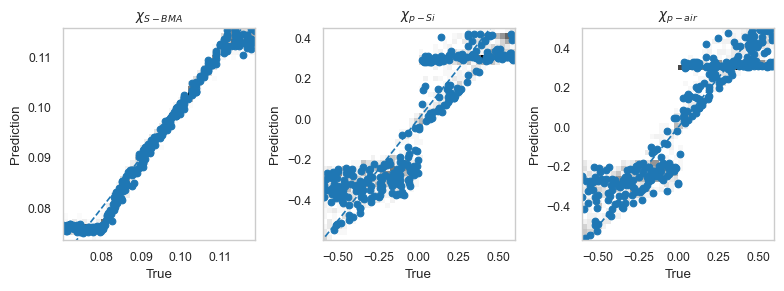

In [29]:
## Create plot of true vs model-predicted chi parameter values

fig, fits = plt.subplots(1, 3, sharey=False, tight_layout=True, dpi=100, figsize=(8, 3))

l0 = plt.subplot(1, 3, 1)
l0.hist2d(df_train_samples.loc[:,'chi1'],df_train_samples.loc[:,'pred_chi1'], bins=40, cmap='Greys')
l0.scatter(df_test_samples.loc[:,'chi1'],df_test_samples.loc[:,'pred_chi1'])
l = mlines.Line2D([-1, 1], [-1, 1], linestyle='--')
l0.add_line(l)
plt.ylabel('Prediction')
l0.set_title('$\chi_{S-BMA}$')
plt.xlabel('True')


l1 = plt.subplot(1, 3, 2)
l1.hist2d(df_train_samples.loc[:,'chi2'],df_train_samples.loc[:,'pred_chi2'], bins=40, cmap='Greys')
l1.scatter(df_test_samples.loc[:,'chi2'],df_test_samples.loc[:,'pred_chi2'])
l = mlines.Line2D([-1, 1], [-1, 1], linestyle='--')
l1.add_line(l)
plt.ylabel('Prediction')
l1.set_title('$\chi_{p-Si}$')
plt.xlabel('True')


l2 = plt.subplot(1, 3, 3)
l2.hist2d(df_train_samples.loc[:,'chi3'],df_train_samples.loc[:,'pred_chi3'], bins=40, cmap='Greys')
l2.scatter(df_test_samples.loc[:,'chi3'],df_test_samples.loc[:,'pred_chi3'])
l = mlines.Line2D([-1, 1], [-1, 1], linestyle='--')
l2.add_line(l)
plt.ylabel('Prediction')
l2.set_title('$\chi_{p-air}$')
plt.xlabel('True')

,l1,l2,chi1,chi2,chi3
0,5.133581,9.14128,-0.042491,-0.323216,-1.088273


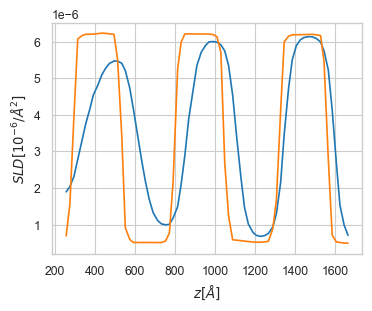

In [35]:
int_expt = np.interp(sld_arr[0][0], expt_arr[0], expt_arr[1])
expt_arr_n = np.asarray([[expt_arr[0], expt_arr[1]]])

expt_labels = []

expt_curve = torch.from_numpy(expt_arr_n[0]).flatten().float()
expt_curve = expt_curve.to(device)

autoencoder.eval()
percep.eval()

with torch.no_grad():
  encoded_expt = autoencoder.encoder(expt_curve)
  decoded_expt = autoencoder.decoder(encoded_expt)
  out_label  = percep(encoded_expt)

encoded_expt = encoded_expt.numpy()
out_label = out_label.numpy()

expt_label = {f"l{i+1}": enc for i, enc in enumerate(encoded_expt)}

for i in range(num_params):
    label_index = 'chi' + str(i+1)
    expt_label[label_index] = out_label[i]

## Rescale our SLD curve back to it's original size
## These numbers are gathered from the file in which the SLDs were originally scaled down
xscaled_decode = (decoded_expt.reshape(in_d1,in_d2).numpy()[0] * (1681.68 - 250.17)) + 250.17
yscaled_decode = (decoded_expt.reshape(in_d1,in_d2).numpy()[1] * (6.232376332701351e-06 - 4.912958904784194e-07)) + 4.912958904784194e-07

xscaled_exp = (decoded_expt.reshape(in_d1,in_d2).numpy()[0] * (1681.68 - 250.17)) + 250.17
yscaled_exp = (int_expt * (6.232376332701351e-06 - 4.912958904784194e-07)) + 4.912958904784194e-07

fig = plt.figure(figsize=(4,3))
plt.plot(xscaled_decode,yscaled_decode) 
plt.plot(xscaled_exp,yscaled_exp)
plt.xlabel('$z[\AA]$')
plt.ylabel('$SLD[10^{-6}/\AA^2]$')

expt_labels.append(expt_label)
df_expt_labels = pd.DataFrame(expt_labels)
df_expt_labels

Text(0, 0.5, '$\\ell_{2}$')

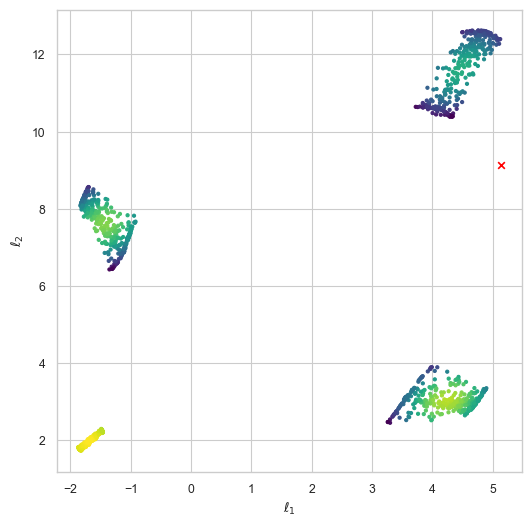

In [36]:
#Plotting the latent space with our experimental data represented as well
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
x = df_encoded_samples['l1']
y = df_encoded_samples['l2']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
sc=ax.scatter(x, y, c=z, s=5, cmap='viridis')
ax.scatter(df_expt_labels['l1'],df_expt_labels['l2'],marker='x', color='red')
ax.set_xlabel('$\ell_{1}$')
ax.set_ylabel('$\ell_{2}$')